# Some basic images transformation

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets

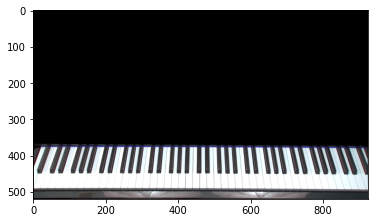

In [2]:
img = cv2.imread('pictures/piano.png')
plt.imshow(img)
plt.show()

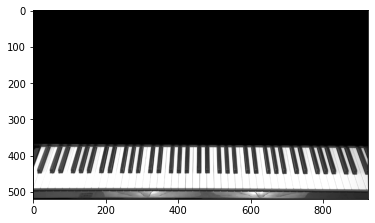

In [3]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
plt.imshow(gray, cmap='gray')
plt.show()

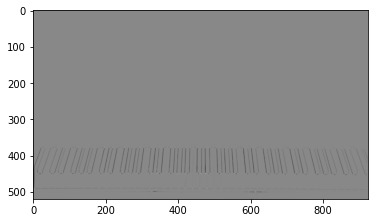

In [4]:
dst = cv2.cornerHarris(gray,2,3,0.04)
plt.imshow(dst, cmap='gray')
plt.show()

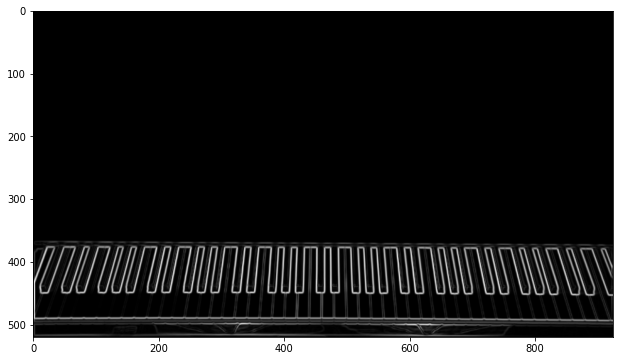

In [5]:
sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=5)
sobel = np.sqrt(sobelx**2 + sobely**2)
plt.figure(figsize=(16,6))
plt.imshow(sobel, cmap='gray')
plt.show()

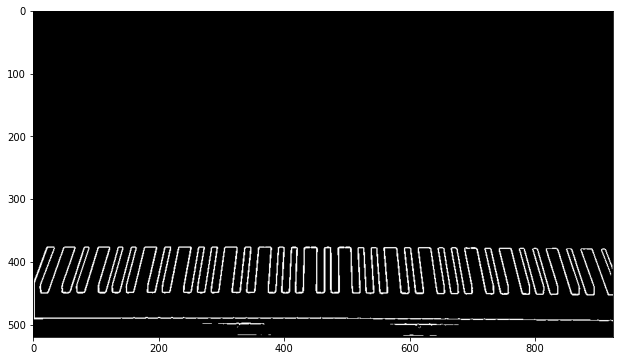

In [6]:
sobel_black_white = sobel.copy()
threshold = 5000
sobel_black_white[sobel_black_white < threshold] = 0
sobel_black_white[sobel_black_white >= threshold] = 1
plt.figure(figsize=(16,6))
plt.imshow(sobel_black_white, cmap='gray')
plt.show()

In [7]:
def sobel_threshold(threshold):
    sobel_black_white = sobel.copy()
    sobel_black_white[sobel_black_white <= threshold] = 0
    sobel_black_white[sobel_black_white > threshold] = 1
    plt.figure(figsize=(16,6))
    plt.imshow(sobel_black_white, cmap='gray')
    plt.show()

interact(sobel_threshold, threshold=widgets.IntSlider(min=0,max=10000,step=100,value=5000))

interactive(children=(IntSlider(value=5000, description='threshold', max=10000, step=100), Output()), _dom_cla…

<function __main__.sobel_threshold(threshold)>

# Video

With Markdown

<video controls src="mp4/Pachelbel.mp4">animation</video>

In [8]:
from IPython.display import Video
Video('mp4/Pachelbel.mp4')

In [9]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets

In [10]:
cap = cv2.VideoCapture('mp4/Pachelbel.mp4') # Open the video file for reading

In [11]:
# Some information about the video

fps = cap.get(cv2.CAP_PROP_FPS)
frame_size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
                int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
print('Frame rate: ', fps)
print('Frame size: ', frame_size)

Frame rate:  29.967791810918403
Frame size:  (1280, 720)


In [12]:
# Here we use the interact function to create a slider to select the frame number

def select_frame(frame_number):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number) # Set the frame number to read
    ret, frame = cap.read() # ret is a boolean that is True if the frame was read correctly
    if ret == True:
        plt.figure(figsize=(16,6))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # Convert from BGR to RGB
        plt.imshow(frame)
        plt.show()
    else:
        print('Frame not found')

interact(select_frame, frame_number=widgets.IntSlider(min=0,max=cap.get(cv2.CAP_PROP_FRAME_COUNT),step=1,value=0))


interactive(children=(IntSlider(value=0, description='frame_number', max=6046), Output()), _dom_classes=('widg…

<function __main__.select_frame(frame_number)>

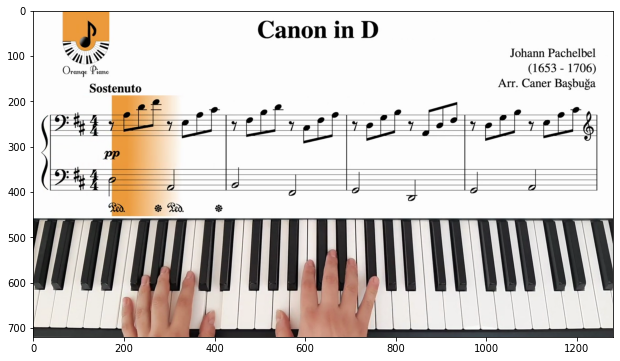

In [13]:
# Get the 100th frame 'img' just to experiment with the code
n = 100
cap.set(cv2.CAP_PROP_POS_FRAMES, n)
ret, frame = cap.read()
plt.figure(figsize=(16,6))
img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

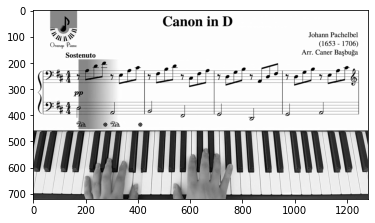

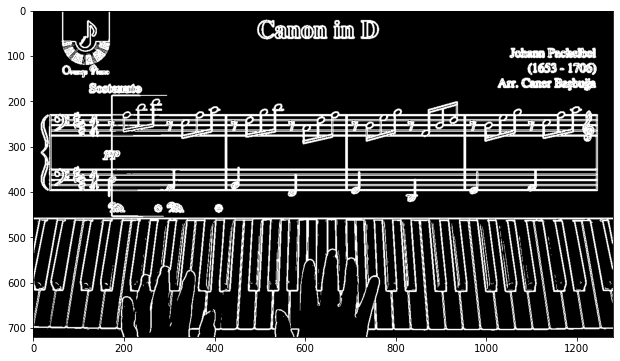

In [14]:
# The goal is to crop the image to the piano keys
# We will use the sobel filter to find the edges of the keys
# We will then use the hough transform to find the lines that represent the keys

# Step 1: Convert to grayscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
plt.imshow(gray, cmap='gray')
plt.show()

# Step 2: Apply the sobel filter
sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=5)
sobel = np.sqrt(sobelx**2 + sobely**2)
sobel = (sobel/sobel.max()*255).astype(np.uint8) # For display purposes and Hough transform
black_white_threshold = 30
sobel[sobel <= black_white_threshold] = 0
sobel[sobel > black_white_threshold] = 255
plt.figure(figsize=(16,6))
plt.imshow(sobel, cmap='gray')
plt.show()


Number of lines found:  11224


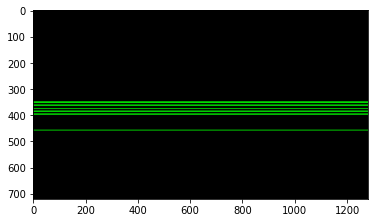

In [15]:
# Step 3: Find the line that separates the piano from the background
# The task is easy here because there is an almost horizontal line that separates the piano from the background
# From the left side of the image to the right side of the image, the line is almost horizontal and continuous
# In order to find the line, we will use the hough transform
# The hough transform will find the lines that are continuous and almost horizontal
# We will then select the line that is closest to the horizontal line

rho_resolution = 1
theta_resolution = np.pi/180
threshold = 155
hough_lines = cv2.HoughLines(image = sobel, rho = rho_resolution, theta = theta_resolution, threshold = threshold)
print('Number of lines found: ', len(hough_lines))

# lines[0][0] is the first line found, of the form [rho, theta] where rho is the distance from the origin and theta is the angle
# The origin is the top left corner of the image
# The lines are represented by the equation r = x*cos(theta) + y*sin(theta)
# Draw the lines
color=[0, 255, 0]
thickness=2
hough_lines_image = np.zeros_like(img)
for i in range(10): #range(len(hough_lines)):
    line = hough_lines[i]
    for rho,theta in line:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + cap.get(cv2.CAP_PROP_FRAME_WIDTH)*(-b))
        y1 = int(y0 + cap.get(cv2.CAP_PROP_FRAME_WIDTH)*(a))
        x2 = int(x0 - cap.get(cv2.CAP_PROP_FRAME_WIDTH)*(-b))
        y2 = int(y0 - cap.get(cv2.CAP_PROP_FRAME_WIDTH)*(a))

        cv2.line(hough_lines_image,(x1,y1),(x2,y2),color,thickness)  

plt.imshow(hough_lines_image)
plt.show()

Number of lines found:  119


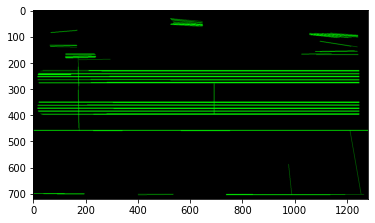

In [16]:
# Now we use cv2.HoughLinesP to find the segments of lines
rho_resolution = 1
theta_resolution = np.pi/180
threshold = 155
hough_lines = cv2.HoughLinesP(image = sobel, rho = rho_resolution, theta = theta_resolution, threshold = threshold,
                            minLineLength = 100, maxLineGap = 10)
print('Number of lines found: ', len(hough_lines))

color=[0, 255, 0]
thickness=1
hough_lines_image = np.zeros_like(img)
for i in range(len(hough_lines)):
    line = hough_lines[i]
    for a,b,c,d in line:
        cv2.line(hough_lines_image,(a,b),(c,d),color,thickness)

plt.imshow(hough_lines_image)
plt.show()

In [17]:
# Now we use sliders for rho, theta, threshold, minLineLength, maxLineGap

def hough_lines_p(rho_resolution, theta_resolution, threshold, minLineLength, maxLineGap):
    rho_resolution = rho_resolution
    theta_resolution = theta_resolution*np.pi/180
    threshold = threshold
    minLineLength = minLineLength
    maxLineGap = maxLineGap
    hough_lines = cv2.HoughLinesP(image = sobel, rho = rho_resolution, theta = theta_resolution, threshold = threshold,
                                minLineLength = minLineLength, maxLineGap = maxLineGap)
    print('Number of lines found: ', len(hough_lines))

    color=[0, 255, 0]
    thickness=10
    hough_lines_image = np.zeros_like(img)
    for i in range(len(hough_lines)):
        line = hough_lines[i]
        for a,b,c,d in line:
            length = np.sqrt((a-c)**2 + (b-d)**2)
            if length > 1270 and abs(b-d) < 10:
                cv2.line(hough_lines_image,(a,b),(c,d),color,thickness)
    original_image_with_hough_lines = cv2.addWeighted(img, 0.8, hough_lines_image, 1, 0)
    plt.imshow(original_image_with_hough_lines)

interact(hough_lines_p, rho_resolution = (1, 1, 1),
            theta_resolution = (1, 1, 1), threshold = (1, 200, 1),
            minLineLength = (1200, 1280, 1), maxLineGap = (1, 40, 1))

# 1,1,100,1240,20 is a good combination


interactive(children=(IntSlider(value=1, description='rho_resolution', max=1, min=1), IntSlider(value=1, descr…

<function __main__.hough_lines_p(rho_resolution, theta_resolution, threshold, minLineLength, maxLineGap)>

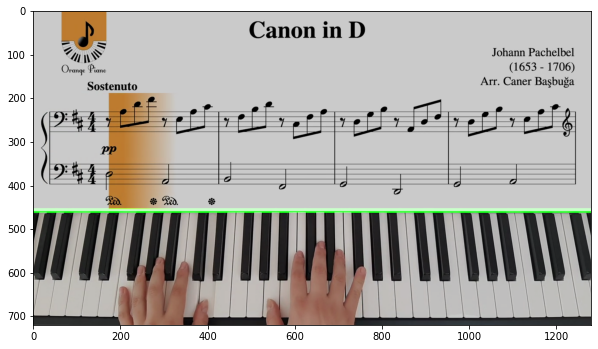

In [18]:
# We clean the code and make a pipeline function 
# that takes an image as input and returns the image with the line that separates the piano from the background

def pipeline(img: np.ndarray) -> np.ndarray: # img is a RGB array
    
    # Step 1: Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Step 2: Apply the sobel filter
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=5)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=5)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    sobel = (sobel/sobel.max()*255).astype(np.uint8) # For display purposes and Hough transform
    black_white_threshold = 30
    sobel[sobel <= black_white_threshold] = 0
    sobel[sobel > black_white_threshold] = 255

    # Step 3: Use the hough transform to find the line that separates the piano from the background
    rho_resolution = 1
    theta_resolution = np.pi/180
    threshold = 100
    minLineLength = 1240
    maxLineGap = 10

    hough_lines = cv2.HoughLinesP(image = sobel, rho = rho_resolution, theta = theta_resolution, threshold = threshold,
                                minLineLength = minLineLength, maxLineGap = maxLineGap)

    color=[0, 255, 0]
    thickness=10
    hough_lines_image = np.zeros_like(img)
    for i in range(len(hough_lines)):
        line = hough_lines[i]
        a,b,c,d = line[0]
        length = np.sqrt((a-c)**2 + (b-d)**2)
        if length > 1270 and abs(b-d) < 10: # We want the line to be almost horizontal and long enough
            cv2.line(hough_lines_image,(a,b),(c,d),color,thickness)
            break # We only want one line
    original_image_with_hough_lines = cv2.addWeighted(img, 0.8, hough_lines_image, 1, 0)
    #plt.figure(figsize=(10,10))
    #plt.imshow(original_image_with_hough_lines)
    #plt.show()
    return original_image_with_hough_lines

plt.figure(figsize=(10,10))
plt.imshow(pipeline(img))
plt.show()

In [19]:
# Use the pipeline function on every frame of the video

def select_frame(frame_number):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number) # Set the frame number to read
    ret, frame = cap.read() # ret is a boolean that is True if the frame was read correctly
    if ret == True:
        plt.figure(figsize=(16,6))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # Convert from BGR to RGB
        result = pipeline(frame)
        plt.imshow(result)
        plt.show()
    else:
        print('Frame not found')

interact(select_frame, frame_number=widgets.IntSlider(min=0,max=cap.get(cv2.CAP_PROP_FRAME_COUNT),step=1,value=0))

interactive(children=(IntSlider(value=0, description='frame_number', max=6046), Output()), _dom_classes=('widg…

<function __main__.select_frame(frame_number)>

In [20]:
# Since the camera does not move, we can use the same line for every frame
# We rewrite the pipeline function to return the line instead of the image (a,b,c,d)

def pipeline(img: np.ndarray) -> np.ndarray: # img is a RGB array
    
    # Step 1: Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Step 2: Apply the sobel filter
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=5)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=5)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    sobel = (sobel/sobel.max()*255).astype(np.uint8) # For display purposes and Hough transform
    black_white_threshold = 30
    sobel[sobel <= black_white_threshold] = 0
    sobel[sobel > black_white_threshold] = 255

    # Step 3: Use the hough transform to find the line that separates the piano from the background
    rho_resolution = 1
    theta_resolution = np.pi/180
    threshold = 100
    minLineLength = 1240
    maxLineGap = 10

    hough_lines = cv2.HoughLinesP(image = sobel, rho = rho_resolution, theta = theta_resolution, threshold = threshold,
                                minLineLength = minLineLength, maxLineGap = maxLineGap)

    for i in range(len(hough_lines)):
        line = hough_lines[i]
        a,b,c,d = line[0]
        length = np.sqrt((a-c)**2 + (b-d)**2)
        if length > 1270 and abs(b-d) < 10: # We want the line to be almost horizontal and long enough
            return a,b,c,d

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = cap.read()
a,b,c,d = pipeline(frame)
a,b,c,d

(0, 459, 1279, 459)

In [21]:
y = b # y is the y coordinate of the line

# Now we can use the line to separate the piano from the background
# Crop the image to keep only the piano

def select_frame(frame_number):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number) # Set the frame number to read
    ret, frame = cap.read() # ret is a boolean that is True if the frame was read correctly
    if ret == True:
        plt.figure(figsize=(16,6))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # Convert from BGR to RGB
        result = frame[y:,:,:]
        plt.imshow(result)
        plt.show()
    else:
        print('Frame not found')

interact(select_frame, frame_number=widgets.IntSlider(min=0,max=cap.get(cv2.CAP_PROP_FRAME_COUNT),step=1,value=0))

interactive(children=(IntSlider(value=0, description='frame_number', max=6046), Output()), _dom_classes=('widg…

<function __main__.select_frame(frame_number)>

In [22]:
# Crop the video to keep only the piano
# Save the video as a new file

fourcc = cv2.VideoWriter_fourcc(*'h264')
out = cv2.VideoWriter('mp4/piano.mp4', # or .mkv
    fourcc, cap.get(cv2.CAP_PROP_FPS),
    (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))-y))

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = cap.read()
while ret:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = frame[y:,:,:]
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    out.write(frame)
    ret, frame = cap.read()

out.release()
cv2.destroyAllWindows() # Close all windows

OpenCV: FFMPEG: tag 0x34363268/'h264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


# This section is useless

I tried to isolate the piano by using medians and means.

In [23]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

<video controls src="mp4/piano.mp4">animation</video>

In [24]:
# reduce the size of the video to make it easier to process
# save the video as a new file

cap = cv2.VideoCapture('mp4/piano.mp4')
k = 0.5 # k is the size reduction factor
fourcc = cv2.VideoWriter_fourcc(*'h264')
out = cv2.VideoWriter('mp4/piano_small.mp4', # or .mkv
    fourcc, cap.get(cv2.CAP_PROP_FPS),
    (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)*k), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)*k)))

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = cap.read()
while ret:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (0,0), fx=k, fy=k)
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    out.write(frame)
    ret, frame = cap.read()

out.release()
cv2.destroyAllWindows() # Close all windows

OpenCV: FFMPEG: tag 0x34363268/'h264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


In [25]:
cap = cv2.VideoCapture('mp4/piano_small.mp4') # Open the video file for reading

<video controls src="mp4/piano_small.mp4">animation</video>

Text(0.5, 1.0, 'Median')

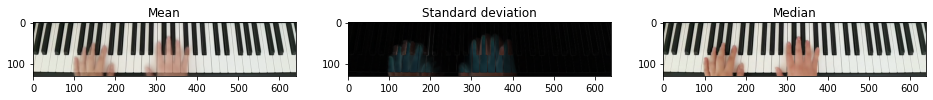

In [26]:
n = 100

# mean of the first n frames
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = cap.read()
mean = np.zeros(frame.shape)
for i in range(n):
    mean += frame
    ret, frame = cap.read()
mean = mean/n

# standard deviation of the first n frames
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = cap.read()
std = np.zeros(frame.shape)
for i in range(n):
    std += (frame - mean)**2
    ret, frame = cap.read()
std = np.sqrt(std/n)

# median of the first n frames at each pixel
array4D = np.zeros((n,frame.shape[0],frame.shape[1],frame.shape[2]))
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = cap.read()
for i in range(n):
    array4D[i] = frame
    ret, frame = cap.read()
median = np.median(array4D, axis=0)

# Display the results
mean = cv2.cvtColor(mean.astype(np.uint8), cv2.COLOR_RGB2BGR)
std = cv2.cvtColor(std.astype(np.uint8), cv2.COLOR_RGB2BGR)
median = cv2.cvtColor(median.astype(np.uint8), cv2.COLOR_RGB2BGR)

plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
plt.imshow(mean)
plt.title('Mean')
plt.subplot(1,3,2)
plt.imshow(std)
plt.title('Standard deviation')
plt.subplot(1,3,3)
plt.imshow(median)
plt.title('Median')


In [27]:
# median of the whole video at each pixel
from tqdm import tqdm
n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
array4D = np.zeros((n,frame.shape[0],frame.shape[1],frame.shape[2]))
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = cap.read()
for i in tqdm(range(n)):
    if ret:
        array4D[i] = frame
    ret, frame = cap.read()

100%|██████████| 6014/6014 [00:03<00:00, 1816.61it/s]


In [28]:
median = np.median(array4D, axis=0) # takes 1 min

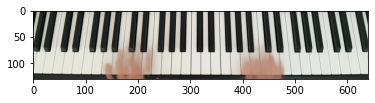

In [29]:
median = cv2.cvtColor(median.astype(np.uint8), cv2.COLOR_RGB2BGR)
plt.imshow(median)
# okay, this doesn't work to isolate the piano

# Mask

In [30]:
# For now, we will just assume that there is a frame where there are no hands
# and that the piano is visible in that frame
# We will use this frame to create a mask that we will use to isolate the piano

import cv2
import numpy as np
from matplotlib import pyplot as plt

In [31]:
cap = cv2.VideoCapture('mp4/piano.mp4')

In [32]:
def show_frame(video, frame_number):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(16,6))
        plt.imshow(frame)
        plt.show()
    else:
        print('Frame not found')

def get_frame(video, frame_number):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        return ret, frame
    else:
        return ret, None

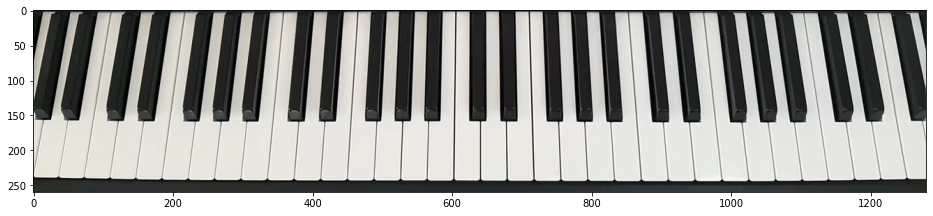

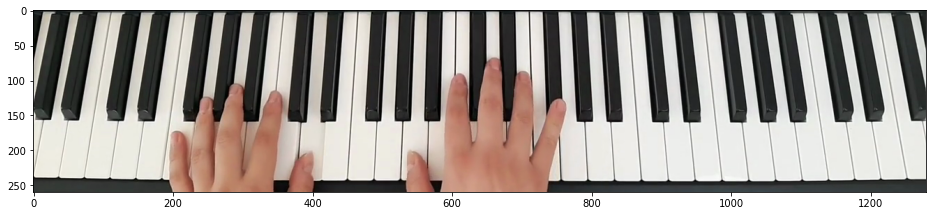

In [33]:
_, frame_mask = get_frame(cap, 0)
_, frame = get_frame(cap, 100)
show_frame(cap, 0)
show_frame(cap, 100)

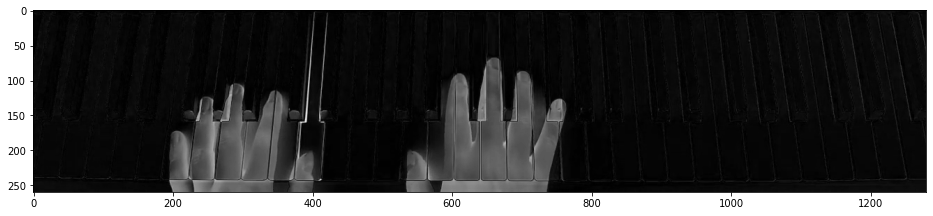

In [34]:
# Isolate the hands by subtracting the mask from the frame
difference = frame.astype(float) - frame_mask.astype(float)
difference = np.abs(difference)
difference = difference.astype(np.uint8)
difference = cv2.cvtColor(difference, cv2.COLOR_RGB2GRAY)
plt.figure(figsize=(16,6))
plt.imshow(difference, cmap='gray')
plt.show()

In [35]:
# Do this for all frames and save as a new video
# 6 min

cap = cv2.VideoCapture('mp4/piano.mp4')
fourcc = cv2.VideoWriter_fourcc(*'h264')
out = cv2.VideoWriter('mp4/piano_isolate_hands.mp4', # or .mkv
    fourcc, cap.get(cv2.CAP_PROP_FPS),
    (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

_, frame_mask = get_frame(cap, 0)
frame_mask = cv2.cvtColor(frame_mask, cv2.COLOR_RGB2GRAY)

n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
for i in tqdm(range(n)):
    ret, frame = get_frame(cap, i)
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    difference = frame.astype(float) - frame_mask.astype(float)
    difference = np.abs(difference)
    difference = difference.astype(np.uint8)
    difference = cv2.cvtColor(difference, cv2.COLOR_GRAY2RGB)
    out.write(difference)

out.release()
cap.release()



OpenCV: FFMPEG: tag 0x34363268/'h264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'
100%|██████████| 6014/6014 [06:25<00:00, 15.61it/s]


In [36]:
# Do this for all frames and save as a new video
# Reducing the number of frames to 1/4 and the resolution to 1/2
# 30 sec

cap = cv2.VideoCapture('mp4/piano_small.mp4')
fourcc = cv2.VideoWriter_fourcc(*'h264')
out = cv2.VideoWriter('mp4/piano_isolate_hands_1_2.mp4', # or .mkv
    fourcc, cap.get(cv2.CAP_PROP_FPS)/4,
    (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

_, frame_mask = get_frame(cap, 0)
frame_mask = cv2.cvtColor(frame_mask, cv2.COLOR_RGB2GRAY)

n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
for i in tqdm(range(0,n,4)):
    ret, frame = get_frame(cap, i)
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    difference = frame.astype(float) - frame_mask.astype(float)
    difference = np.abs(difference)
    difference = difference.astype(np.uint8)
    difference = cv2.cvtColor(difference, cv2.COLOR_GRAY2RGB)
    out.write(difference)

out.release()
cap.release()



OpenCV: FFMPEG: tag 0x34363268/'h264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'
100%|██████████| 1504/1504 [00:35<00:00, 42.97it/s]


# Detection of pressed key

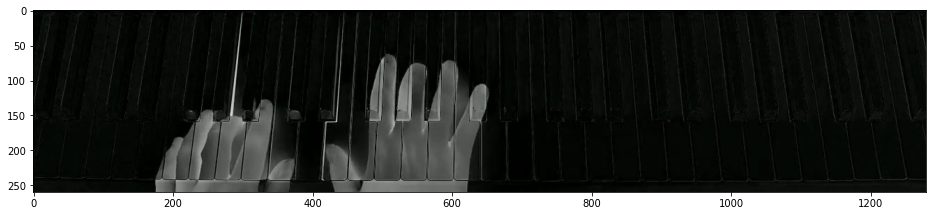

In [37]:
cap = cv2.VideoCapture('mp4/piano_isolate_hands.mp4')

_, frame = get_frame(cap, 100)
show_frame(cap, 175)

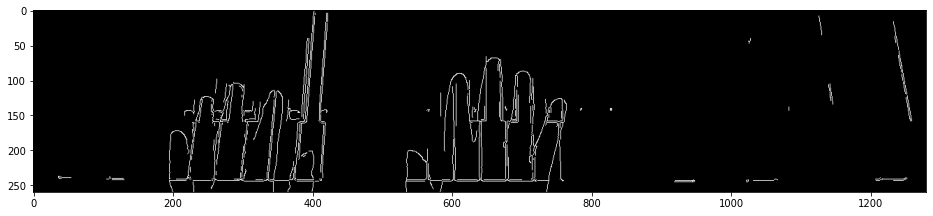

In [38]:
# The goal is to detect the keys that are pressed
# There are many edges, but we have to choose the ones that have a sufficient width

# First, we will try to detect the edges
# We will use the Canny edge detector
# https://docs.opencv.org/3.4/da/d22/tutorial_py_canny.html

edges = cv2.Canny(frame, 100, 200)
plt.figure(figsize=(16,6))
plt.imshow(edges, cmap='gray')
plt.show()

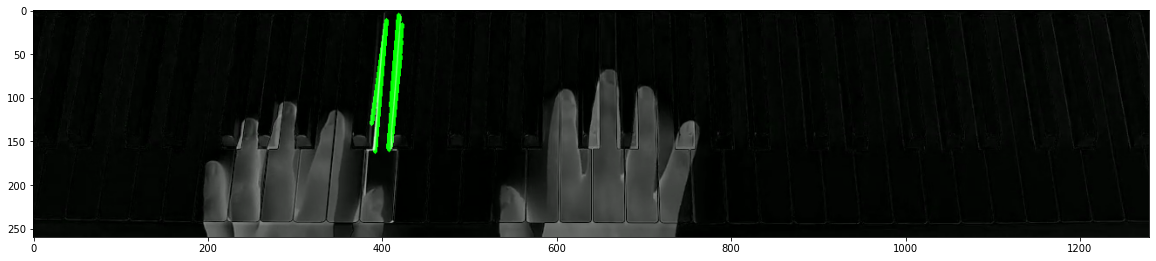

In [39]:
# What about Hough segments?
# https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html

# We clean the code and make a pipeline function 
# that takes an image as input and returns the image with the line that separates the piano from the background

def pipeline(img, sobel_threshold=30, hough_threshold=100, hough_min_line_length=100, hough_max_line_gap=10):
    
    # Step 1: Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Step 2: Apply the sobel filter
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=9)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=9)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    sobel = (sobel/sobel.max()*255).astype(np.uint8) # For display purposes and Hough transform
    sobel[sobel <= sobel_threshold] = 0
    sobel[sobel > sobel_threshold] = 255

    #plt.imshow(sobel, cmap='gray')

    # Step 3: Use the hough transform to find the line that separates the piano from the background
    rho_resolution = 1
    theta_resolution = np.pi/180
    threshold = hough_threshold
    minLineLength = hough_min_line_length
    maxLineGap = hough_max_line_gap

    hough_lines = cv2.HoughLinesP(image = sobel, rho = rho_resolution, theta = theta_resolution, threshold = threshold,
                                minLineLength = minLineLength, maxLineGap = maxLineGap)

    color=[0, 255, 0]
    thickness=4
    hough_lines_image = np.zeros_like(img)
    if hough_lines is not None:
        for i in range(len(hough_lines)):
            line = hough_lines[i]
            a,b,c,d = line[0]
            if abs(a-c) < 40 and (b < 70 or d < 70) and (b < 180 and d < 180):
                # piano keys are vertical and must start at the top of the image, and be above hands
                cv2.line(hough_lines_image, (a,b), (c,d), color, thickness)
        original_image_with_hough_lines = cv2.addWeighted(img, 0.8, hough_lines_image, 1, 0)
    else:
        original_image_with_hough_lines = img
    return original_image_with_hough_lines

plt.figure(figsize=(20,10))
plt.imshow(pipeline(frame))
plt.show()

In [40]:
# We can now apply the pipeline to all the frames of the video
# and save the result as a new video

cap = cv2.VideoCapture('mp4/piano_isolate_hands.mp4')
fourcc = cv2.VideoWriter_fourcc(*'h264')
out = cv2.VideoWriter('mp4/piano_key_detector.mp4', # or .mkv
    fourcc, cap.get(cv2.CAP_PROP_FPS),
    (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
for i in tqdm(range(n)):
    ret, frame = get_frame(cap, i)
    if not ret:
        break
    frame = pipeline(frame)
    out.write(frame)

out.release()
cap.release()

OpenCV: FFMPEG: tag 0x34363268/'h264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'
  0%|          | 0/6014 [00:00<?, ?it/s]/var/folders/k2/9pyp10v51ynbycnr07rllv100000gn/T/ipykernel_32028/1408619603.py:16: RuntimeWarning: invalid value encountered in true_divide
  sobel = (sobel/sobel.max()*255).astype(np.uint8) # For display purposes and Hough transform
100%|██████████| 6014/6014 [08:36<00:00, 11.65it/s]


In [43]:
# use widgets
# first parameter is whether we use canny or sobel
# second parameter is frame number
# third parameter is the threshold for canny or sobel

cap = cv2.VideoCapture('mp4/piano_isolate_hands.mp4')

def show_frame_with_pipeline(canny: bool, frame_number: int, threshold1: int, threshold2: int):
    _, frame = get_frame(cap, frame_number)
    if canny:
        edges = cv2.Canny(frame, threshold1, threshold2)
        plt.figure(figsize=(10,10))
        plt.imshow(edges, cmap='gray')
    else:
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=5)
        sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=5)
        sobel = np.sqrt(sobelx**2 + sobely**2)
        sobel = (sobel/sobel.max()*255).astype(np.uint8) # For display purposes and Hough transform
        if threshold2 < 100: # just to use as boolean
            sobel[sobel <= threshold1] = 0
            sobel[sobel > threshold1] = 255
        plt.figure(figsize=(10,10))
        plt.imshow(sobel, cmap='gray')
    plt.show()
    plt.figure(figsize=(10,10))
    plt.imshow(frame)
    plt.show()

interact(show_frame_with_pipeline, canny=True, frame_number=(0, 1000, 1), threshold1=(0, 255, 1), threshold2=(0, 255, 1))

interactive(children=(Checkbox(value=True, description='canny'), IntSlider(value=500, description='frame_numbe…

<function __main__.show_frame_with_pipeline(canny: bool, frame_number: int, threshold1: int, threshold2: int)>

In [44]:
def show_frame_with_pipeline(frame_number1, frame_number2, sobel_threshold, hough_threshold, min_line_length, max_line_gap):
    ret, frame = get_frame(cap, 100*frame_number1+frame_number2)
    if not ret:
        return
    frame = pipeline(frame, sobel_threshold, hough_threshold, min_line_length, max_line_gap)
    plt.figure(figsize=(10,10))
    plt.imshow(frame)
    plt.show()

interact(show_frame_with_pipeline, frame_number1=(0, 70, 1), frame_number2=(0, 100, 1), 
    sobel_threshold=(0, 120, 1), hough_threshold=(0, 200, 1), min_line_length=(0, 120, 1), max_line_gap=(0, 30, 1))

# sobel_threshold=60, hough_threshold=100, hough_min_line_length=100, hough_max_line_gap=40
# 47,77,60,100,40,40 yields problems
# _,_,60,100,60,15

interactive(children=(IntSlider(value=35, description='frame_number1', max=70), IntSlider(value=50, descriptio…

<function __main__.show_frame_with_pipeline(frame_number1, frame_number2, sobel_threshold, hough_threshold, min_line_length, max_line_gap)>

In [45]:
# get the audio from "Pachelbel.mp4"
# and add to the video "piano_key_detector.mp4" using only cv2

from moviepy.editor import VideoFileClip, AudioFileClip, CompositeAudioClip

video = VideoFileClip("mp4/piano_key_detector.mp4")
audio = AudioFileClip("mp4/Pachelbel.mp4")
video = video.set_audio(audio)
video.write_videofile("mp4/piano_key_detector_with_audio.mp4")

# use ffmpeg to add the audio to the video
# ffmpeg -i piano_key_detector.mp4 -i Pachelbel.mp4 -c:v copy -c:a aac -strict experimental piano_key_detector_with_audio.mp4

Moviepy - Building video mp4/piano_key_detector_with_audio.mp4.
MoviePy - Writing audio in piano_key_detector_with_audioTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video mp4/piano_key_detector_with_audio.mp4



Moviepy - Done !
Moviepy - video ready mp4/piano_key_detector_with_audio.mp4


# Making regions for keys

The goal is to detect the piano keys boundaries in order to isolate them

In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from tqdm import tqdm


In [14]:
def show_frame(video, frame_number):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(16,6))
        plt.imshow(frame)
        plt.show()
    else:
        print('Frame not found')

def get_frame(video, frame_number):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        return ret, frame
    else:
        return ret, None

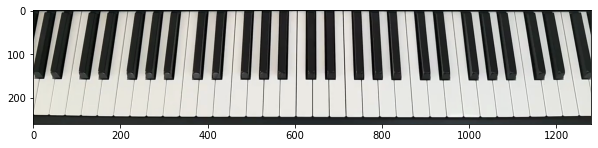

In [15]:
cap = cv2.VideoCapture('mp4/piano.mp4')
_, frame = get_frame(cap, 0)
plt.figure(figsize=(10,10))
plt.imshow(frame)


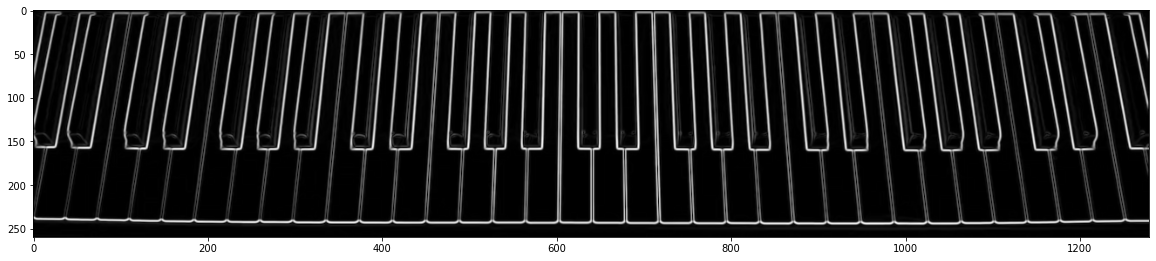

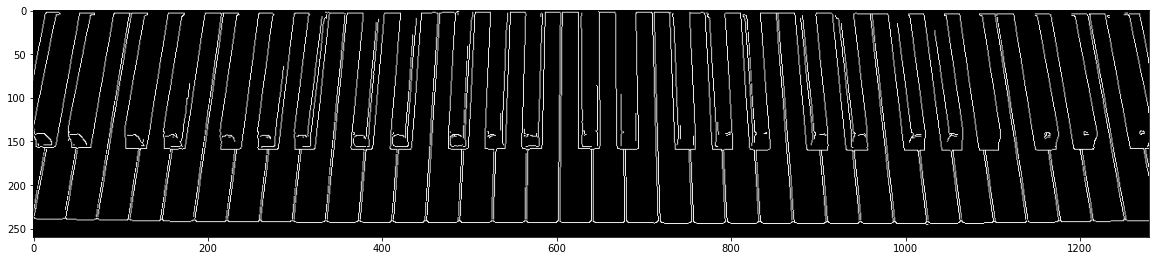

In [16]:
# Sobel or Canny or Hough can be used to detect edges

# Sobel
gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=5)
sobel = np.sqrt(sobelx**2 + sobely**2)

# Canny
canny = cv2.Canny(frame, 100, 250)


# Display
plt.figure(figsize=(20,10))
plt.imshow(sobel, cmap='gray')
plt.show()
plt.figure(figsize=(20,10))
plt.imshow(canny, cmap='gray')
plt.show()



In [17]:
# use slider for canny

def show_frame_with_canny(threshold1, threshold2):
    _, frame = get_frame(cap, 0)
    edges = cv2.Canny(frame, threshold1, threshold2)
    plt.figure(figsize=(20,10))
    plt.imshow(edges, cmap='gray')
    plt.show()
    plt.figure(figsize=(10,10))
    plt.imshow(frame)
    plt.show()

interact(show_frame_with_canny, threshold1=(0, 200, 1), threshold2=(150, 255, 1))


interactive(children=(IntSlider(value=100, description='threshold1', max=200), IntSlider(value=202, descriptio…

<function __main__.show_frame_with_canny(threshold1, threshold2)>

In [18]:
def min_pooling(img, kernel_size):
    img = img.copy()
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    img = cv2.erode(img, kernel, iterations=1)
    img = cv2.dilate(img, kernel, iterations=1)
    return img

In [47]:
# slider for threshold for sobel, and with min pooling and connected components

def show_sobel(threshold):
    _, frame = get_frame(cap, 0)
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=5)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=5)
    sobel = np.sqrt(10*sobelx**2 + sobely**2) # 10 is a scaling factor to make the vertical edges more visible
    sobel_with_threshold = sobel.copy()
    sobel_with_threshold[sobel_with_threshold <= threshold] = 255
    sobel_with_threshold[sobel_with_threshold > threshold] = 0
    sobel_with_threshold[0:5,:] = 0 # make a white line to separate the black keys
    sobel_with_threshold = sobel_with_threshold.astype(np.uint8)
    plt.figure(figsize=(20,10))
    plt.imshow(sobel_with_threshold, cmap='gray')
    plt.show()

    ret, labels = cv2.connectedComponents(sobel_with_threshold)
    print(len(np.unique(labels)))
    plt.figure(figsize=(20,10))
    plt.imshow(labels, cmap='gray')
    plt.show()

interact(show_sobel, threshold=(1000, 5000, 1))

interactive(children=(IntSlider(value=3000, description='threshold', max=5000, min=1000), Output()), _dom_clas…

<function __main__.show_sobel(threshold)>

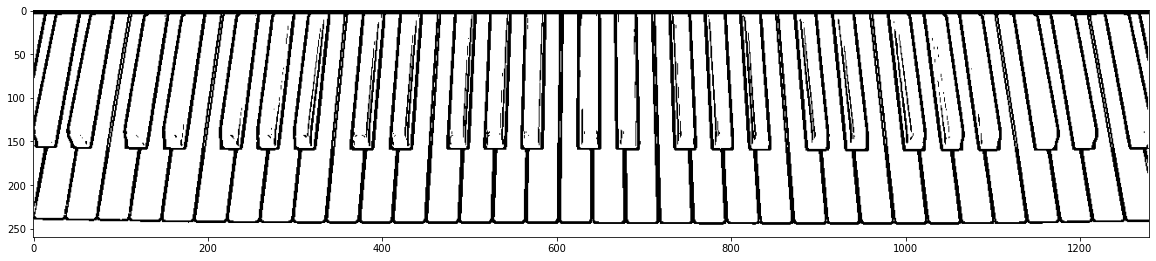

The number of keys is 60


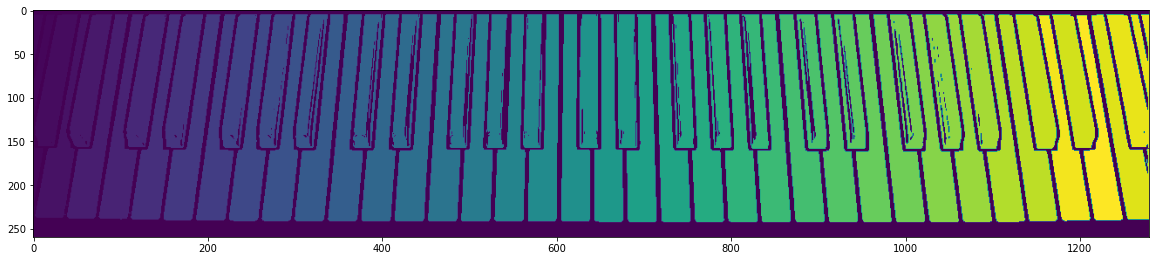

In [83]:
_, frame = get_frame(cap, 0)
gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=5)
sobel = np.sqrt(10*sobelx**2 + sobely**2) # 10 is a scaling factor to make the vertical edges more visible

# threshold
threshold = 5000
sobel_with_threshold = sobel.copy()
sobel_with_threshold[sobel_with_threshold <= threshold] = 255
sobel_with_threshold[sobel_with_threshold > threshold] = 0
sobel_with_threshold[0:5,:] = 0 # make a white line to separate the black keys
sobel_with_threshold = sobel_with_threshold.astype(np.uint8)

# min pooling along horizontal axis to remove some holes between the keys where y is betweent 157 and 240
for i in range(157, 240):
    for j in range(3, 1280-3):
        if (sobel_with_threshold[i, j] == 255
            and (sobel_with_threshold[i, j-1] == 0 or sobel_with_threshold[i, j-2] == 0 or sobel_with_threshold[i, j-3] == 0)
            and (sobel_with_threshold[i, j+1] == 0 or sobel_with_threshold[i, j+2] == 0 or sobel_with_threshold[i, j+3] == 0)):
            sobel_with_threshold[i, j] = 0
plt.figure(figsize=(20,10))
plt.imshow(sobel_with_threshold, cmap='gray')
plt.show()

# get the connected components
ret, labels = cv2.connectedComponents(sobel_with_threshold)

# some connected components are too small, so we remove them
for i in range(1, len(np.unique(labels))):
    if np.sum(labels == i) < 500:
        labels[labels == i] = 0
# the second biggest connected component is the background at the bottom so we remove it
# (the biggest connected component are the edges)
labels[labels == np.argsort(np.bincount(labels.flatten()))[-2]] = 0

# rename the connected components
labels[labels > 0] = 255
labels = labels.astype(np.uint8)
ret, labels = cv2.connectedComponents(labels)
number = len(np.unique(labels))
labels[labels > 0] = labels[labels > 0] #+ 20 # add 20 to the labels to make the regions easier to see
print("The number of keys is", number-1) # -1 because 0 is the background

plt.figure(figsize=(20,10))
plt.imshow(labels)
plt.show()

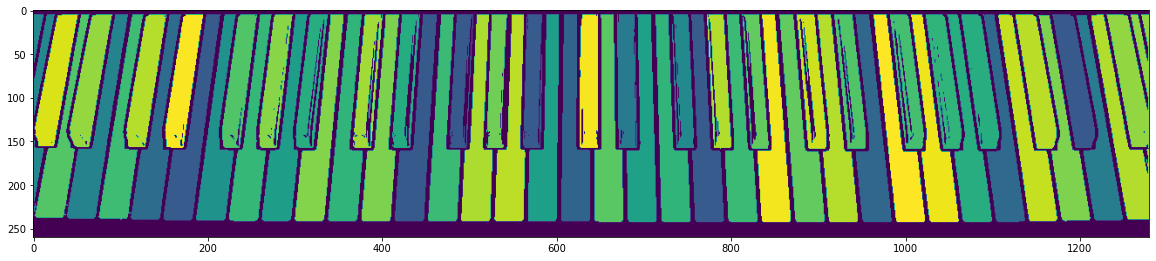

In [84]:
# (optional) assigning random colors to the connected components in order to distinguish them
labels2 = labels.copy()
dictionary = {}
for i in range(1, number+1):
    dictionary[i] = np.random.randint(70, 255)
for i in range(1, number+1):
    labels2[labels2 == i] = dictionary[i]

plt.figure(figsize=(20,10))
plt.imshow(labels2)
plt.show()

In [85]:
# highlighting each keys

def highlight_key(labels, key_number):
    # where labels == key_number, set new_labels to 255,
    # where labels == 0, set new_labels to 0,
    # where labels != key_number and labels != 0, set new_labels to 100
    new_labels = np.zeros_like(labels)
    new_labels[labels == key_number] = 255
    new_labels[labels == 0] = 0
    new_labels[(labels != key_number) & (labels != 0)] = 100
    return new_labels

# slider for key number
def show_key(key_number):
    plt.figure(figsize=(20,10))
    plt.imshow(highlight_key(labels, key_number), cmap='gray')
    plt.show()

interact(show_key, key_number=(1, number-1, 1))

interactive(children=(IntSlider(value=30, description='key_number', max=60, min=1), Output()), _dom_classes=('…

<function __main__.show_key(key_number)>

In [86]:
# the key numbers are not in the right order, so we need to reorder them by using
# the x coordinates of the centroids of the connected components

# get the centroids of the connected components
centroids = [(i, np.mean(np.where(labels == i), axis=1)[1]) for i in range(1, number)]

# reorder the keys
keys = sorted(centroids, key=lambda x: x[1])

# reassigning the labels
new_labels = np.zeros_like(labels)
for i in range(1, number):
    new_labels[labels == keys[i-1][0]] = i

# highlighting each keys
def show_key(key_number):
    plt.figure(figsize=(20,10))
    plt.imshow(highlight_key(new_labels, key_number), cmap='gray')
    plt.show()

interact(show_key, key_number=(1, number-1, 1))



interactive(children=(IntSlider(value=30, description='key_number', max=60, min=1), Output()), _dom_classes=('…

<function __main__.show_key(key_number)>

In [87]:
centroids = [(i,np.mean(np.where(new_labels == i), axis=1)[0])
            for i in range(2, number-1)] # we exclude the first and last keys because they are not complete
# only keep the index of the black keys which have a y-centroid between less than 100
black_keys = [c[0] for c in centroids if c[1] < 100]

In [121]:
# Goal : erase the noise in the black keys
# We will use the fact that the black keys are convex
# So we will find the convex hull of each black key and fill it with white

from scipy.spatial import ConvexHull, Delaunay

# get the convex hull of each black key
def get_convex_hull(labels, key_number):
    # get the coordinates of the pixels of the key
    X,Y = np.where(labels == key_number)
    # in order to simplify the convex hull and make things faster, (25% faster)
    # we will only keep the points that are on the border of the key (y < 20 or y > 120)
    Y = Y[(X < 20) | (X > 120)]
    X = X[(X < 20) | (X > 120)]
    # get the convex hull
    hull = ConvexHull(np.array([X,Y]).T)
    return hull

# check if a point is inside a convex hull
def is_inside_hull(hull, point):
    # get the vertices of the convex hull
    vertices = hull.points[hull.vertices]
    # get the Delaunay triangulation of the vertices
    tri = Delaunay(vertices)
    # check if the point is inside the convex hull
    return tri.find_simplex(point) >= 0

# fill the convex hull of a black key with white
def fill_hull(labels, key_number):
    new_labels = labels.copy()
    # get the convex hull
    hull = get_convex_hull(new_labels, key_number)
    # fill the convex hull with white
    # get xmin, xmax, ymin, ymax of the convex hull to limit the search
    xmin = np.min(hull.points[hull.vertices,0])
    xmax = np.max(hull.points[hull.vertices,0])
    ymin = np.min(hull.points[hull.vertices,1])
    ymax = np.max(hull.points[hull.vertices,1])
    for x in range(int(xmin), int(xmax)+1):
        for y in range(int(ymin), int(ymax)+1):
            if new_labels[x,y] == 0 and is_inside_hull(hull, (x,y)):
                new_labels[x,y] = key_number
    return new_labels

# fill the convex hull of each black key with white
new_labels_filled = new_labels.copy()
for i in tqdm(black_keys):
    new_labels_filled = fill_hull(new_labels_filled, i)


100%|██████████| 24/24 [00:04<00:00,  5.92it/s]


In [120]:
# highlighting each keys
def show_key(key_number):
    plt.figure(figsize=(20,10))
    plt.imshow(highlight_key(new_labels_filled, key_number), cmap='gray')
    plt.show()

interact(show_key, key_number=(1, number-1, 1))

interactive(children=(IntSlider(value=30, description='key_number', max=60, min=1), Output()), _dom_classes=('…

<function __main__.show_key(key_number)>

# Trying to fix the problem of the sligthly moving piano

<video controls src="mp4/piano_isolate_hands.mp4">animation</video>

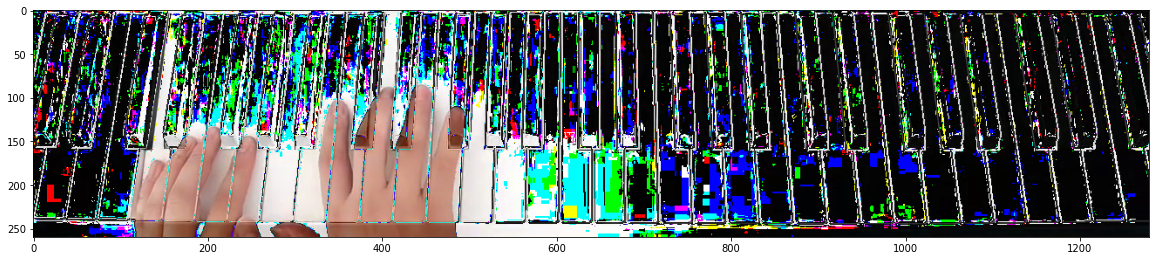

In [77]:
cap = cv2.VideoCapture('mp4/piano.mp4')
_, mask = get_frame(cap, 0)
plt.figure(figsize=(20,10))
plt.imshow(frame - mask)

In [76]:
# slider to see the difference between two frames
# first parameter is frame number

cap = cv2.VideoCapture('mp4/piano.mp4')

def show_frame_difference(frame_number):
    _, frame1 = get_frame(cap, 0)
    _, frame2 = get_frame(cap, frame_number)
    plt.figure(figsize=(20,10))
    difference = frame2 - frame1 - 5
    gray = cv2.cvtColor(difference, cv2.COLOR_RGB2GRAY)
    plt.imshow(gray, cmap='gray')
    plt.show()

interact(show_frame_difference, frame_number=(0, 230, 1))

interactive(children=(IntSlider(value=115, description='frame_number', max=230), Output()), _dom_classes=('wid…

<function __main__.show_frame_difference(frame_number)>

In [83]:
_, frame1 = get_frame(cap, 0)
_, frame2 = get_frame(cap, 115)
plt.figure(figsize=(20,10))
difference = frame2 - frame1 - 5
gray = cv2.cvtColor(difference, cv2.COLOR_RGB2GRAY)


<Figure size 1440x720 with 0 Axes>

interactive(children=(IntSlider(value=127, description='threshold1', max=255), IntSlider(value=127, descriptio…

<function __main__.denoise(threshold1, threshold2)>